### document.py
- [awesome-devblog : feeds](https://awesome-devblog.now.sh/api/korean/people/feeds)

In [221]:
# %%writefile ./document.py
import os, re, csv, requests, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
from tqdm import trange
from bs4 import BeautifulSoup
from wordcloud import WordCloud

class KEYS(Enum):
    # -1 : 아직 라벨링 안함 (default)
    # 0  : 개발과 관련없는 문서
    # 1  : 개발과 관련있는 문서
    LABEL = 'label'
    
    # TAGS + TITLE + DESC
    TEXT = 'text'
    
    # DATA_URL 결과 파싱용 Keys(Beans)
    ID = '_id'
    TITLE = 'title'
    DESC = 'description'
    TAGS = 'tags'
    LINK = 'link'
    
    def getDocKeys():
        return [KEYS.ID.value, KEYS.TITLE.value, KEYS.DESC.value, KEYS.TAGS.value, KEYS.LINK.value]
    
    def getTitleBlackList():
        return ['', 'about']
    
    def getTextKeys():
        return [KEYS.TAGS.value, KEYS.TITLE.value, KEYS.DESC.value]

class Document():
    
    def __init__(self, update=True):
        
        # Constant
        self.DATA_URL = 'https://awesome-devblog.now.sh/api/korean/people/feeds'
        self.DOCUMENTS_PATH = './data/documents.csv'
        self.MAX_REQ_SIZE = 5000
        
        if update:
            self.updateDocs()

        # 전체 데이터
        self.data = self._getDocs()
        
        # 라벨링된 데이터
        self.labeled_data = self.data.loc[self.data.label != -1]
        
    def _getTotal(self):
        """
        전체 문서 개수 요청
        """
        res = requests.get(self.DATA_URL, { 'size': 1 })
        res.raise_for_status()
        doc = res.json()
        return doc['total'][0]['count']

    def _reqDoc(self, page, size, preprocessing=False):
        """
        문서 요청
        - page는 0 부터 시작
        - 전처리(self._preprocessing) 후 반환
        """
        page += 1
        params = {
            'sort': 'date.asc',
            'page': page,
            'size': size
        }
        res = requests.get(self.DATA_URL, params)
        res.raise_for_status()
        doc = res.json()
        
        # json to dataframe
        doc = pd.DataFrame(doc['data'], columns=KEYS.getDocKeys())
        
        # add label
        doc.insert(0, KEYS.LABEL.value, -1)
        
        if preprocessing:
            return self._preprocessing(doc)
        else:
            return doc
    
    def _preprocessing(self, doc, joinTags=True):
        """
        문서 전처리
        - KEYS 이외의 key 삭제
        - [tag] list join to string
        - [title / description / tags] 영어, 한글, 공백 이외의 것들 모두 삭제
        - html tag 삭제
        - \n, \r 삭제
        - 2번 이상의 공백 1개로 통합
        - 영어 대문자 소문자로 변환
        - 앞뒤 공백 삭제
        - text 컬럼 생성 : text = tags + title + description
        """
        
        # title, description, tags
        def textPreprocessing(x):
            x = BeautifulSoup(str(x), "html.parser").get_text()
            x = re.sub('[^가-힣a-zA-Z\s]', '', x)
            return x
        
        # all
        def docPreprocessing(x):
            x = re.sub('[\n\r]', '', x)
            x = re.sub('\s{2,}', ' ', x)
            x = x.lower()
            x = x.strip()
            return x
        
        for key in doc.columns:
            if joinTags and KEYS(key) == KEYS.TAGS:
                doc[key] = doc[key].apply(lambda x: ' '.join(x))
            if key in KEYS.getTextKeys():
                doc[key] = doc[key].apply(textPreprocessing)
                
            if key in KEYS.getDocKeys():
                doc[key] = doc[key].apply(docPreprocessing)
            
        # remove blacklist
        doc = doc.drop(doc[doc[KEYS.TITLE.value].isin(KEYS.getTitleBlackList())].index).reset_index()
                        
        # create text column
        join_with = lambda x: ' '.join(x.dropna().astype(str))
        doc[KEYS.TEXT.value] = doc[KEYS.getTextKeys()].apply(
            join_with,
            axis=1
        )
        return doc
        

    def _reqDocs(self, size, start_page=0):
        """
        전체 문서 요청
        """
        total = self._getTotal()
        if size > self.MAX_REQ_SIZE: size = self.MAX_REQ_SIZE
        total_req = round(total/size + 0.5)
        docs = pd.DataFrame()
        for i in trange(start_page, total_req):
            doc = self._reqDoc(i, size)
            if docs.empty:
                docs = doc
            else:
                docs = docs.append(doc)
        return self._preprocessing(docs)
    
    def _getDocs(self):
        """
        전체 문서 조회
        """
        if not os.path.isfile(self.DOCUMENTS_PATH):
            print('> 문서가 없으므로 서버에 요청합니다.')
            self.updateDocs()
        return pd.read_csv(self.DOCUMENTS_PATH, delimiter=',', dtype={KEYS.LABEL.value: np.int64})
    
    def updateDocs(self):
        """
        최신 문서 추가
        - 데이터가 없는 경우, 전체 데이터를 가져옴
        - 기존 데이터가 있는 경우, 없는 데이터만 추가
        """
        size = self.MAX_REQ_SIZE
        
        if not os.path.isfile(self.DOCUMENTS_PATH):
            # 데이터가 없는 경우
            docs = self._reqDocs(size)
            docs.to_csv(self.DOCUMENTS_PATH, sep=",", index=False)
        else:
            # 기존 데이터가 있는 경우
            num_new_docs = 0
            docs = pd.read_csv(self.DOCUMENTS_PATH, delimiter=',')
            total = self._getTotal()
            total_docs = len(docs)
            new_docs_num = total - total_docs
            new_docs = self._reqDocs(size, total_docs // size)
            
            # _id가 기존 데이터에 존재하지 않는 경우에만 추가
            docs = docs.append(new_docs[~new_docs[KEYS.ID.value].isin(docs[KEYS.ID.value])])
            docs.to_csv(self.DOCUMENTS_PATH, sep=",", index=False)
            
            if total_docs == len(docs):
                print('> 문서가 최신 상태입니다.')
            else:
                print(f'> 신규 문서 {len(docs) - total_docs}개 추가')
    
    def syncDocLabel(self, old_document_path, sep, override=False):
        """
        기존 라벨링한 데이터를 신규 문서에 반영
        - title, link 기준으로 일치하는 문서 검색
        """
        
        document = pd.read_csv(self.DOCUMENTS_PATH, delimiter=',')
        old_document = pd.read_csv(old_document_path, delimiter=sep)
        self._preprocessing(old_document, joinTags=False)
        for index, row in old_document.iterrows():
            link = row.link
            title = row.title
            label = int(row.label)
            if not len(document.loc[document.title.str.strip() == title.strip()]) and not len(document.loc[document.link == link]):
                print(f'not found : {row.title}')
            elif len(document.loc[document.title.str.strip() == title.strip()]):
                document.loc[document.title.str.strip() == title.strip(), KEYS.LABEL.value] = label
            elif len(document.loc[document.link == link]):
                document.loc[document.link == link, KEYS.LABEL.value] = label
        
        # save synchronized document
        if override:
            document.to_csv(self.DOCUMENTS_PATH, sep=",", index=False)
        print('done')
        
    def countAnalysis(self):
        """
        데이터 수량 조사
        """
        labled_data = self.data.loc[self.data.label != -1]
        total_data=len(self.data)
        total_labeled_data=len(labled_data)
        total_dev_data = len(labled_data.loc[labled_data.label == 1])
        total_non_dev_data = len(labled_data.loc[labled_data.label == 0])
        if total_labeled_data != 0:
            ratio_dev_Data = round(total_dev_data/total_labeled_data, 3)
            ratio_non_dev_data = round(total_non_dev_data/total_labeled_data, 3)
        print('> 데이터 수량 조사')
        print(f'전체 데이터 수: {total_data}개')
        print(f'라벨링된 데이터 수: {total_labeled_data}개')
        print(f'개발 문서 수: {total_dev_data}개')
        print(f'비개발 문서 수: {total_non_dev_data}개')
        if total_labeled_data != 0:
            print(f'개발 문서 : 비개발 문서 = {ratio_dev_Data} : {ratio_non_dev_data}')
    
    def analysis(self):
        self.countAnalysis()
        self.textAnalysis()
        self.showWordCloud(self.data.text)
    
    def textAnalysis(self):
        """
        text 길이 분석
        """
        labled_data = self.data.loc[self.data.label != -1]
        total_labled_data = len(labled_data)
        labled_text_len = labled_data.text.apply(len)
        text_len = self.data.text.apply(len)
        plt.figure(figsize=(12, 5))
        plt.hist(text_len, bins=200, alpha=0.5, color= 'r', label='all text')
        plt.hist(labled_text_len, bins=200, alpha=0.5, color= 'b', label='labeled text')
        plt.legend(fontsize='x-large')
        plt.yscale('log', nonposy='clip')
        plt.title('Log-Histogram of length of text')
        plt.xlabel('Length of text')
        plt.ylabel('Number of text')

        corpus = [text_len, labled_text_len] if total_labled_data != 0 else [text_len]
        for i, l in enumerate(corpus):
            print('')
            if i == 0:
                print('> 문장 길이 분석 : all text')
            else:
                print('> 문장 길이 분석 : labeled text')
            print('문장 길이 최대 값: {}'.format(np.max(l)))
            print('문장 길이 최소 값: {}'.format(np.min(l)))
            print('문장 길이 평균 값: {:.2f}'.format(np.mean(l)))
            print('문장 길이 표준편차: {:.2f}'.format(np.std(l)))
            print('문장 길이 중간 값: {}'.format(np.median(l)))

            # 사분위의 대한 경우는 0~100 스케일로 되어있음
            print('문장 길이 제 1 사분위: {}'.format(np.percentile(l, 25)))
            print('문장 길이 제 3 사분위: {}'.format(np.percentile(l, 75)))
            
    def showWordCloud(self, text):
        """
        WordCloud
        """
        # 한글 폰트 깨짐방지
        for font in ["/Library/Fonts/NanumGothic.ttf", "/Library/Fonts/NotoSansCJKkr-Light.otf"]:
            if os.path.isfile(font):
                FONT_PATH = font
                break
        cloud = WordCloud(font_path=FONT_PATH).generate(" ".join(text))
        plt.figure(figsize=(20, 15))
        plt.imshow(cloud)
        plt.axis('off')

In [222]:
doc = Document(update=False)

> 데이터 수량 조사
전체 데이터 수: 34620개
라벨링된 데이터 수: 10382개
개발 문서 수: 7634개
비개발 문서 수: 2748개
개발 문서 : 비개발 문서 = 0.735 : 0.265

> 문장 길이 분석 : all text
문장 길이 최대 값: 358
문장 길이 최소 값: 3
문장 길이 평균 값: 145.02
문장 길이 표준편차: 60.59
문장 길이 중간 값: 132.0
문장 길이 제 1 사분위: 108.0
문장 길이 제 3 사분위: 203.0

> 문장 길이 분석 : labeled text
문장 길이 최대 값: 352
문장 길이 최소 값: 4
문장 길이 평균 값: 179.88
문장 길이 표준편차: 57.48
문장 길이 중간 값: 201.0
문장 길이 제 1 사분위: 147.0
문장 길이 제 3 사분위: 219.0


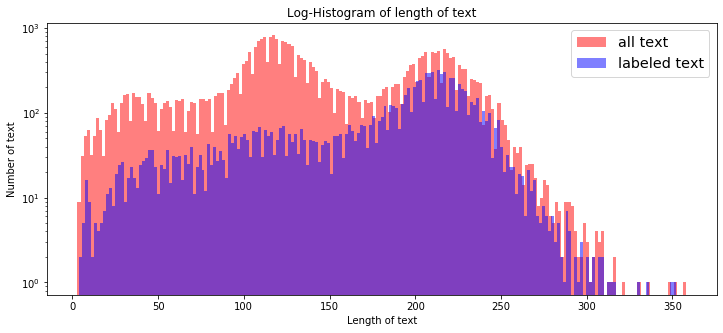

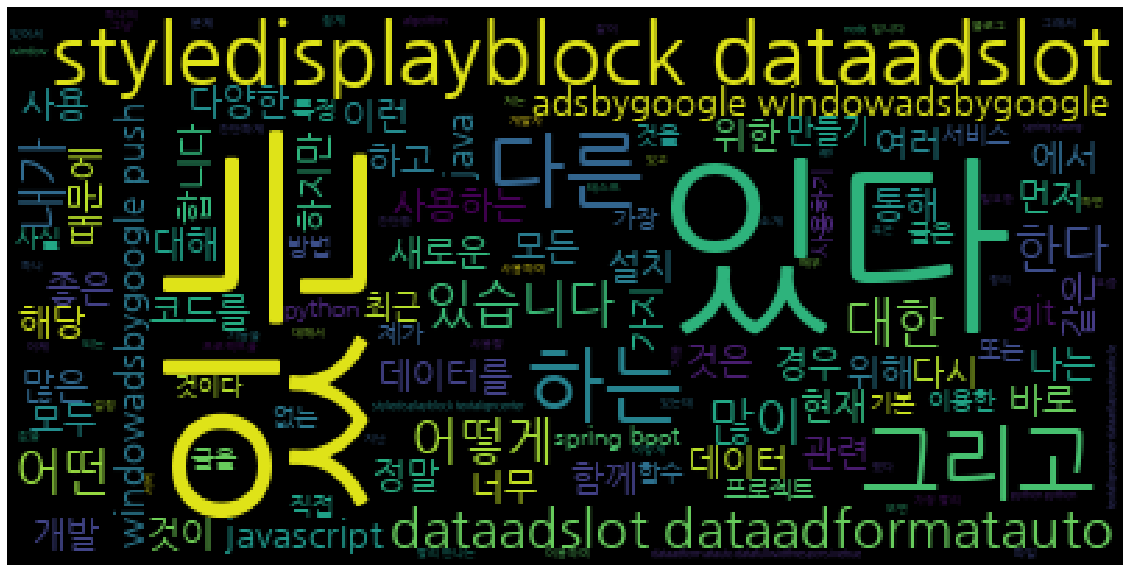

In [223]:
doc.analysis()

In [224]:
doc.labeled_data[['label', 'text']]

,label,text
10,0,about me 뭐하세요 전남대학교 전자컴퓨터공학부 재학 뭐했어요 전남대학교 동아...
386,0,근황 제 블로그에 들어와본지도 오래됐네요 북마크를 잘못 눌러서 제 블로그에 들어왔...
554,0,년 월 일 년이 시작한 지도 벌써 이틀이 지나 월 일 다른 블로그에서 년을 마무리...
644,0,hello world hello world this is the beginning...
760,0,근황 dfest 장려상 deview 첫날 bof 시간에 croquisjs 발표자로...
...,...,...
34516,1,unityd tilemap 룰 타일로 타일맵 자동 연결하기 tilemap 룰 타일...
34517,1,code review 애자일과 소프트웨어 장인정신 코드 리뷰를 왜 해야 하나 가끔 ...
34518,0,paper staring into the abyss an evaluation of...
34545,1,b급 프로그래머 월 주 소식개발관리도구 고성능 서버데이터베이스 부문 오늘의 짤방 ...
